# Echo state network on Lorenz and Sin dataset

### Author: Daniel Mai 

In [320]:
import matplotlib.pyplot as plt
# make sure plots are correctly displayed in the notebook
%matplotlib inline
import numpy as np

### Reading from files 

In [321]:
def read_file(file_name='lorenz.txt'):
    data = np.genfromtxt(file_name, delimiter='\n', dtype=float)
    return data

### Process the dataset based on the k-step ahead forecasting

- Note: the input dimension I used in this project is 1

- Pair data will be split based on k
    - The value of time step t will be paired with the value of time step t+k
    - io_pair $\in R^{(N - k) x 2}$ where N is the number of datas.
    - train_pair $\in R^{(N - k - k) x 2}$ which is used to train the model.
    - test_pair $\in R^{k x 2}$ which is used to test the model.

In [335]:
def train_test_split(data, k=20, test_size=0.3):
    '''
        Args:
            data : original data read from files (N,)
            k    : steps for ahead forecasting
            test_size : should be between 0 and 1
        Returns: 
            io_pair ((N-k,2)) : input-output pair of whole data
            train_pair ((N-k-k,2)) : input-output training pair  
            test_pair ((k,2)) : input-output test pair
        
    '''
    io_pair = np.zeros((len(data) - k, 2), dtype=float)

    for i in range(len(data) - k):
        io_pair[i, 1] = data[i + k] # setting the output
        io_pair[i, 0] = data[i]
        
    split = io_pair.shape[0] - int(len(data) * test_size)
    train_pair = io_pair[:split, :]
    test_pair = io_pair[split:, :]
    
    return io_pair, train_pair, test_pair

### Initialize randomized weights

- Elements of **$W^i$** is independently drawn from a uniform distribution in [−1, 1]
- Elements of **$W^r$** directly impacts on the “dynamics” of the network and therefore requires more:
    - uniformly in [-1, 1]
    - $W^r = a\frac{W_r}{p(W^r)}$ where $p(W^r)$ is the spectral radius of $W^r$ and **a** is a scalar hyper-parameter.

In [259]:
def initialize_weights(input_dim, a, n_reservoirs):
    '''
        Args:
            input_dim   : input dimensions
            a           : scalar - hyper-parameter
            n_reservoirs: number of reservoir neurons
        Returns:
            W_in: input-to-recurrent layer weights
            W_r: recurrent layer weights
    '''
    
    W_in = (np.random.rand(n_reservoirs, input_dim) - 0.5) * 1
    W_r = np.random.rand(n_reservoirs, n_reservoirs) - 0.5
    
    # compute the spectral radius of these weights
    spectral_radius = max(abs(np.linalg.eig(W_r)[0]))
    
    # rescale W_r
    W_r = (W_r*a)/spectral_radius
    
    return W_in, W_r

### Metrics for evaluating prediction performance

* Mean-squared error (MSE)

$$
MSE = 〈||t-z||^2〉
$$

    where〈·〉indicates average over time, t and z are target and predicted values, respectively.


* Normalized root MSE (NRMSE)

$$
NRMSE = \frac{\sqrt{MSE}}{var(t)}
$$

In [374]:
def MSE(target, predicted):
    '''
    Args:
        target: target values
        predicted: predicted values
    Returns:
        loss of the model
    '''
    return np.square(np.subtract(target,predicted)).mean()

def NRMSE(target, predicted):
    return MSE(target, predicted)/np.var(target)

### Implement ESN network

#### Standard ESN model:

$x^t = \phi(W^r x_{t-1} + W^i u_t)$         

$z_t = W^o x_t$                             

- where $W^r$ and $W^i$ are randomly initialized, and $W^o$ is obtained as a solution to a (regularized) least-square problem

    - $W^r \in R^{N_r x N_r}$, where $N_r$ is the number of neurons in the recurrent layer (reservoir)
    - $W^i \in R^{N_r x N_i}$ is the input-to-reservoir weight matrix, $N_i$ is the input dimension
    - $W^o \in R^{N_o x N_r}$ is the read-output weight matrix, $N_o$ is the output dimension 
    - Activation function $\phi(x)$, I will use in this project is the **tanh** activation function 
    
    - **NOTE**: In this project, **N_o** and **N_i** is equal to 1 since we are dealing with ***unidimensional*** dataset



- The state $x_t$ can be seen as a vector of **temporal features**

- The sequence of states $x_t, t = 1,..., N$ is the **representation learned** by the ESN of the driving input $u_t$, $t = 1,...,N$

#### Ridge regression for the read-out weights

- Regularized least-square problem for $W_o$: 

    arg min $\frac{1}{2}||XW - t||^2 + \frac{\lambda}{2}||W||^2$ where $\lambda >= 0$ is the *regularization parameter*
    
    
- The closed form solution for the above problem is:

    $W^o = (X^TX + \lambda I)^{-1}X^Tt$ where **I** is an $N_r x N_r$ identity matrix
    
    - $W^o$ should be **transposed** before further use in the model
    
    
- Assume a supervised task (such as forecasting) and dataset $\{u_i, t_i\}^N_{i=1}$

Steps for **batch training**:
1. Initialize all model parameters $W^i$, $W^r$
2. Initialize the first state as $x_0 = 0$
3. Feed the network with the sequence of inputs $u_i$, i = 1, ...,N
4. Collect the resulting N states $x_i$ in a matrix $X \in R^{N x N_r}$
5. Store all related targets in a N-dimensional vector $t \in R^N$
6. Find $W^o$ by solving a regularized least-square problem

In [278]:
def ESN_train(train_pair, n_reservoirs=200, a=0.95, lamda=0.01):
    '''
        Args:
            train_pair ((N,2)) : training input-output pair  where N is number of training pairs
            n_reservoirs       : number of reservoir neurons
            a                  : scalar - hyper-parameter used for initialize recurrent weights 
            lamda              : hyper-parameter used in ridge regression for read-out weights
        Returns:
            W_in               : input-to-recurrent layer weights
            W_r                : recurrent layer weights
            W_out ((, N_r))    : read-output weight matrix
    '''
    n_inputs = train_pair.shape[0]
    
    # initialize all model weights/parameters
    # Note: I hardcoded the input dimension (= 1) here
    #       since the input data set is unidimensional.
    W_i, W_r = initialize_weights(1, a, n_reservoirs) 
    
    # initialize the first state
    x = np.zeros((n_reservoirs, 1))
    
    # initialize holder for collecting N states x_i in a matrix X 
    X = np.zeros((n_inputs, n_reservoirs))
    
    # Feed the network with sequence of inputs u_i
    # and collect the resulting N states x_i in a matrix X.
    # NOTE: I used tanh for the activation funtion
    for i in range(n_inputs):
        u = np.array(train_pair[i, 0]) # inputs
        x = np.tanh(np.dot(W_r, x) + np.dot(W_i, u))  
        X[i, :] = x.squeeze()
    
    # Store all targeted values for those training inputs in a N-dimensional vector
    t = np.array(train_pair[:, 1])
    t = np.expand_dims(t, axis=0)
    
    # calculating W_o by solving the regularized least-square problem
    X = X.T
    W_o = np.linalg.solve(np.dot(X, X.T) + np.multiply(lamda,np.identity(n_reservoirs)), np.dot(X, t.T)).T
    return x, W_i, W_r, W_o

Steps for **prediction**:

1. initialize a holder for the predicted values $\in 1 x M$ where M is the number of testing pairs
2. Get the input time value and applied the model to find the predicted values
3. Store the predicted value in the holder
4. find the loss after the loop of finding all predicted values from given input time.

In [369]:
def ESN_k_step_predict(test_pair, x, W_in, W_r, W_out, k=20):
    '''
        Args:
            training_pair    : training input-output pair ((N,2)) where N is number of training pairs
            x                : current state after finish training
            W_in ((N_r, 1))  : input-to-recurrent layer weights
            W_r ((N_r, N_r)) : recurrent layer weights
            W_out ((1, N_r)) : optimized read-output weight matrix
            k                : steps for ahead forecasting (hyperparameter)
        Returns:
            loss             : MSE loss of the model
            targeted_values  : 
            predicted_values : 
    '''
    
    # intialize holder for predicted time series
    test_len = test_pair.shape[0]
    predicted_values = np.zeros((1,test_len)) 
    
    
    for t in range(test_pair.shape[0]):
        u = np.array(test_pair[t,0]) # get the input time value
        x = np.tanh(np.dot(W_in,u) + np.dot(W_r,x))
        z = np.dot(W_out, x)
        predicted_values[:,t] = z
        

    targeted_values = np.expand_dims(test_pair[:,1], axis=0)

    loss = NRMSE(targeted_values, predicted_values)
    
    return loss, targeted_values, predicted_values
    

### Plot Functions

In [370]:
def plot_function(data, predicts, k=20, a=0.95, reservoir=200):
    plt.figure(figsize=(11, 1.5)).clear()
    plt.plot(range(0, len(data)), data.T, 'k', label="target system")
    plt.plot(range(len(data)-len(predicts.T.squeeze()), len(data)), predicts.T, 'r', label='predicted system' )
    plt.title(" Prediction for num_reservoirs = " + str(reservoir) + "a = " + str(a))
    plt.legend(['target system', 'predict system'])

In [371]:
def plot_result_function(targets, predicts, k=20, a=0.95, reservoir=200):
    plt.figure(figsize=(10, 3)).clear()
    plt.plot( targets.T, 'r' )
    plt.plot( predicts.T, 'b' )
    plt.title(' prediction for k = ' + str(k) + " num_reservoirs = " +str(reservoir) + " a = " + str(a))
    plt.legend(['targets', 'predicts'])

### Experiments on Lorenz datatset

In [372]:
lorenz_data = read_file('lorenz.txt')

Evaluate the following hyperparameters: **n_reservoirs** and **training_size**

for num reservoirs = 200 and training_size = 0.8 --> NRMSE loss: 0.0016166156832814332
for num reservoirs = 200 and training_size = 0.7 --> NRMSE loss: 0.002257203244165192
for num reservoirs = 200 and training_size = 0.6 --> NRMSE loss: 0.0040275953730594125
for num reservoirs = 200 and training_size = 0.5 --> NRMSE loss: 0.0038123466735027894
for num reservoirs = 300 and training_size = 0.8 --> NRMSE loss: 0.001203097425461154
for num reservoirs = 300 and training_size = 0.7 --> NRMSE loss: 0.001752523916368446
for num reservoirs = 300 and training_size = 0.6 --> NRMSE loss: 0.0023401784439880747
for num reservoirs = 300 and training_size = 0.5 --> NRMSE loss: 0.001991371610094201
for num reservoirs = 400 and training_size = 0.8 --> NRMSE loss: 0.0010314437360158836
for num reservoirs = 400 and training_size = 0.7 --> NRMSE loss: 0.0012415755321025063
for num reservoirs = 400 and training_size = 0.6 --> NRMSE loss: 0.001710096984121761
for num reservoirs = 400 and training_size = 0.5

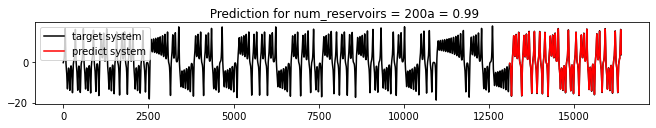

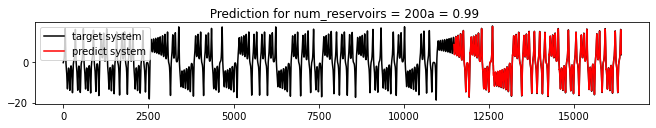

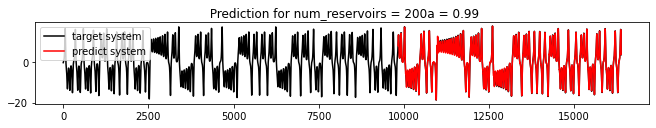

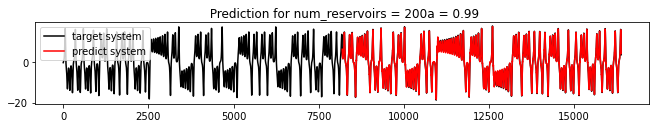

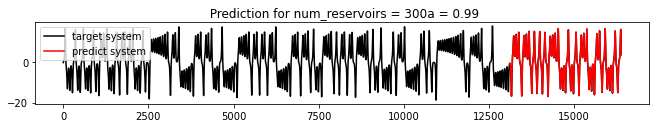

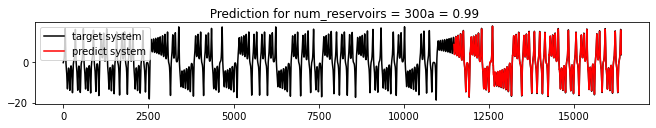

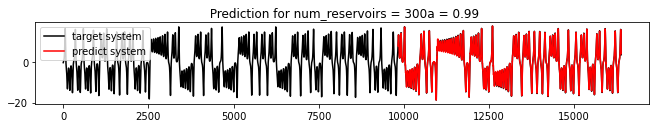

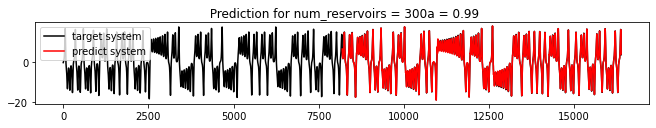

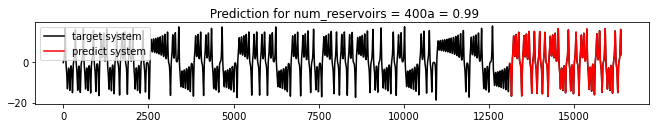

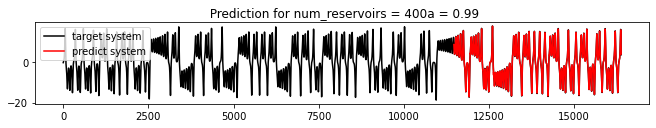

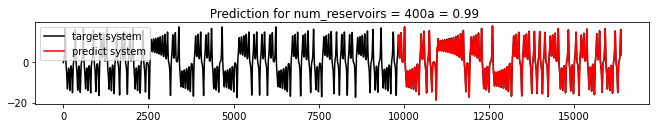

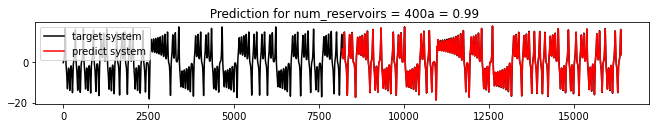

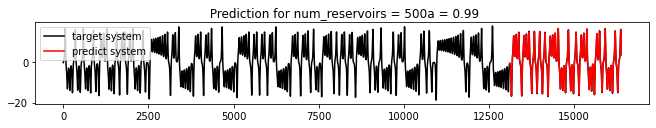

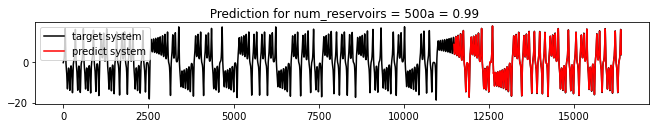

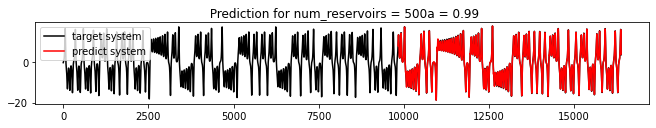

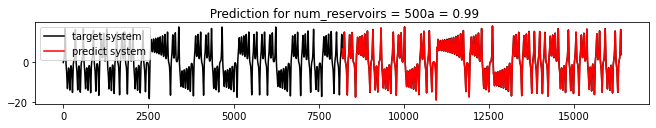

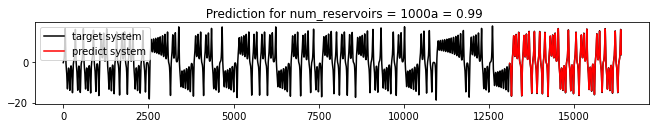

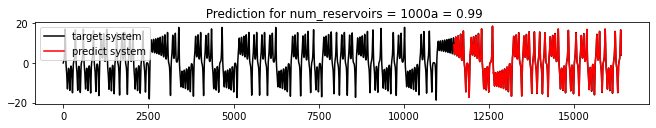

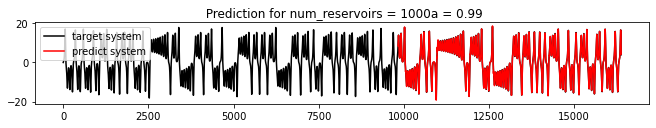

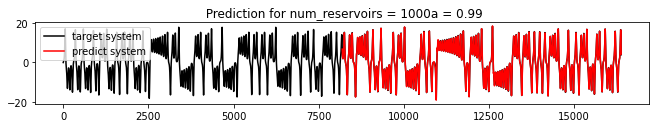

In [375]:
n_reservoirs = [200, 300, 400, 500, 1000]
test_size = [0.2, 0.3, 0.4, 0.5] # training_size = 1 - test_size

for num_reservoir in n_reservoirs:
    for size in test_size:
        io_pair, lorenz_train_pair, lorenz_test_pair = train_test_split(lorenz_data,test_size=size)
        lorenz_current_state, lorenz_W_in, lorenz_W_r, lorenz_W_out = ESN_train(lorenz_train_pair, n_reservoirs=num_reservoir)
        lorenz_test_loss, lorenz_targets, lorenz_predicts = ESN_k_step_predict(lorenz_test_pair,
                                                          lorenz_current_state,
                                                          lorenz_W_in,
                                                          lorenz_W_r,
                                                          lorenz_W_out)
        print('for num reservoirs = ' + str(num_reservoir) + ' and training_size = ' + str(1-size) + ' --> NRMSE loss: '+ str(lorenz_test_loss))
        plot_function(lorenz_data, lorenz_predicts, k, a, num_reservoir)

Reports: 
- Best performance: num_reservoirs = 1000 and training_size = 80% of the data.
- The very first thing I observed is that Echo state network can be trained very fast because they just fit a linear model, they can do impressive modeling of one-dimensional time-series!
- They demonstrate that its very important to initialize weights sensibly
- For fixed k and a, the change of number of reservoirs change the reconstruction, and as the number of reservoirs increase, the error starts decrease.
- For fixed k and a, error did not decrease monotonically with number of training examples. A possible explanation for this could be that during the high test error training periods, the data was subject to different perturbations than during testing.


Evaluate the following hyperparameters: **k - forecasting horizon**

for k = 10 --> MSE loss: 0.0038404472906332426
for k = 20 --> MSE loss: 0.024371890254934754
for k = 50 --> MSE loss: 5.500950592673185
for k = 100 --> MSE loss: 25.3394041092661
for k = 250 --> MSE loss: 60.07586225322176


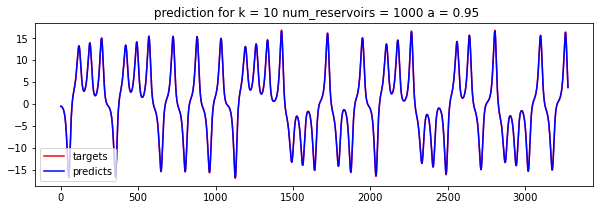

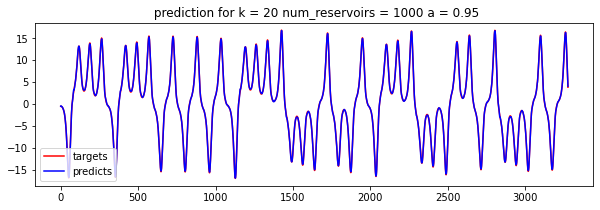

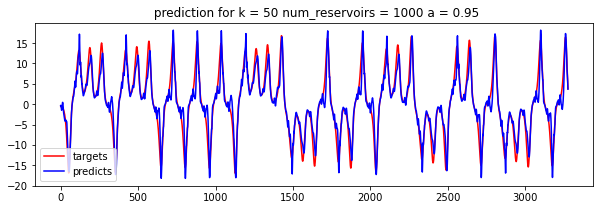

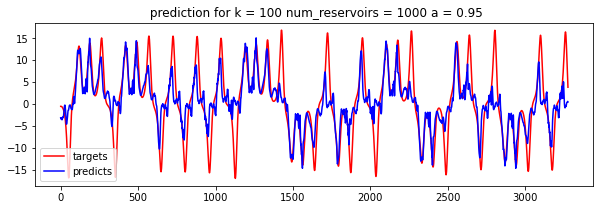

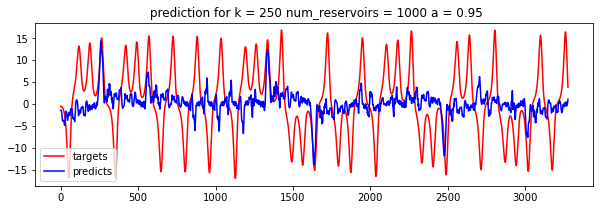

In [376]:
k_tests = [10, 20, 50, 100, 250]

for k in k_tests: 
    io_pair, lorenz_train_pair, lorenz_test_pair = train_test_split(lorenz_data, k=k, test_size=0.2)
    lorenz_current_state, lorenz_W_in, lorenz_W_r, lorenz_W_out = ESN_train(lorenz_train_pair, n_reservoirs=1000)
    lorenz_test_loss, lorenz_targets, lorenz_predicts = ESN_k_step_predict(lorenz_test_pair,
                                                          lorenz_current_state,
                                                          lorenz_W_in,
                                                          lorenz_W_r,
                                                          lorenz_W_out,
                                                          k=k)
    print('for k = ' + str(k) + ' --> MSE loss: '+ str(MSE(lorenz_targets, lorenz_predicts)))
    plot_result_function(lorenz_targets, lorenz_predicts, k, 0.95, 1000)

Reports:
- As the number of k increases longer (higher), the error is increasing rapidly
- A possible explanation for this phenomenon is that, as k increases, the total pair of data is decreases, thus less data to train and test. Moreover, the higher of k, the more far distance from the input to output is. So, it is hard to predict perfectly for the long step.

### Experiments on 2sin dataset

In [341]:
sin_data = read_file('2sin.txt')

 Evaluate the following hyperparameters: **n_reservoirs** and **training_size**

for num reservoirs = 200 and training_size = 0.8 --> NRMSE loss: 0.0045924586151555175
for num reservoirs = 200 and training_size = 0.7 --> NRMSE loss: 0.008101700531427993
for num reservoirs = 200 and training_size = 0.6 --> NRMSE loss: 0.008704171268750557
for num reservoirs = 200 and training_size = 0.5 --> NRMSE loss: 0.0038713270399155014
for num reservoirs = 300 and training_size = 0.8 --> NRMSE loss: 0.0047937666549958124
for num reservoirs = 300 and training_size = 0.7 --> NRMSE loss: 0.004744675402354625
for num reservoirs = 300 and training_size = 0.6 --> NRMSE loss: 0.00482890744000475
for num reservoirs = 300 and training_size = 0.5 --> NRMSE loss: 0.0022085098716475553
for num reservoirs = 400 and training_size = 0.8 --> NRMSE loss: 0.0010392695832092032
for num reservoirs = 400 and training_size = 0.7 --> NRMSE loss: 0.0019464100038081346
for num reservoirs = 400 and training_size = 0.6 --> NRMSE loss: 0.0030984368953148956
for num reservoirs = 400 and training_size = 0.5

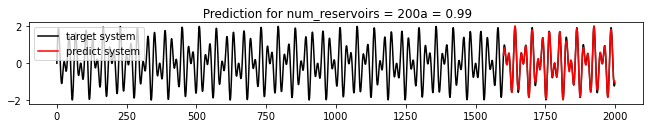

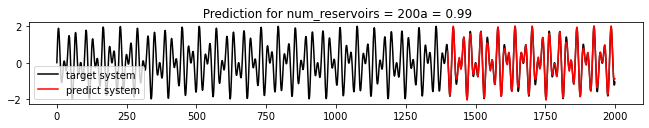

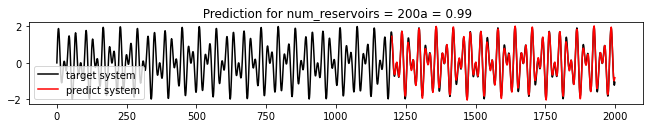

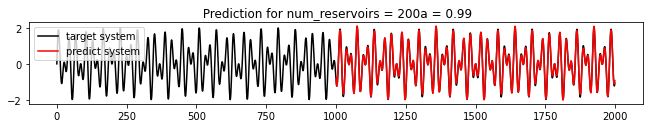

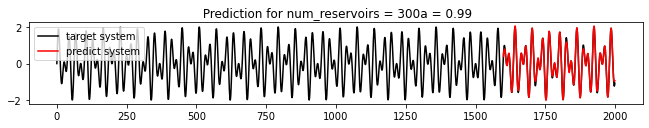

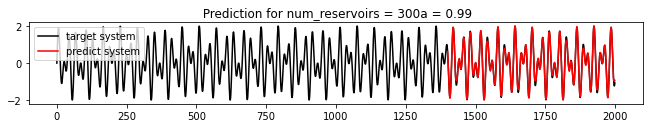

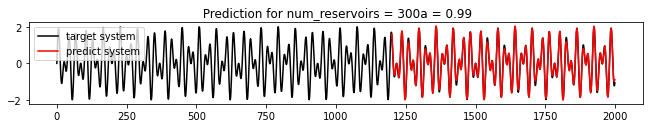

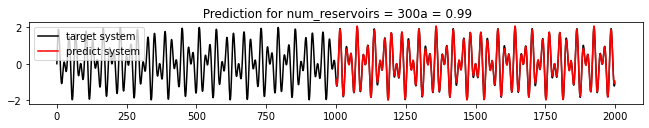

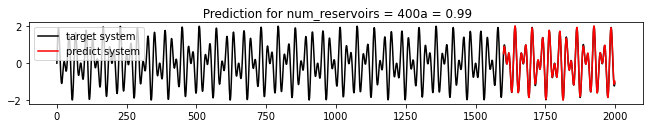

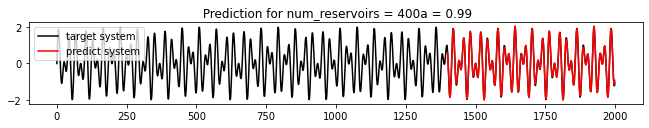

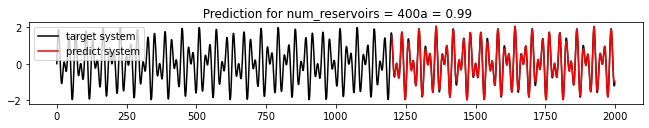

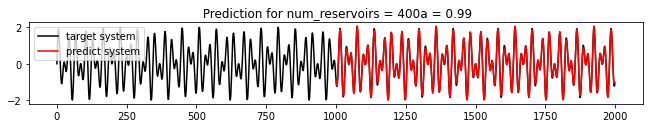

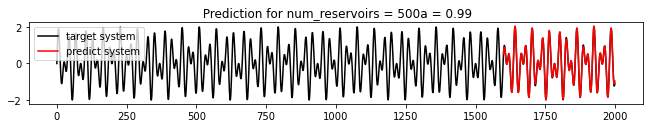

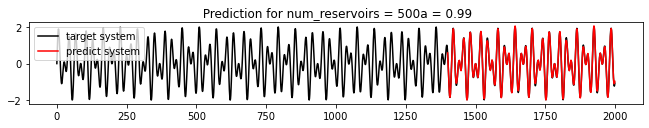

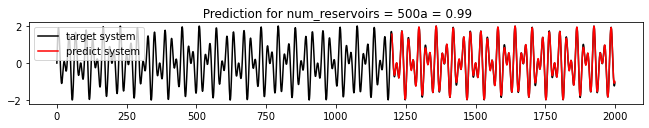

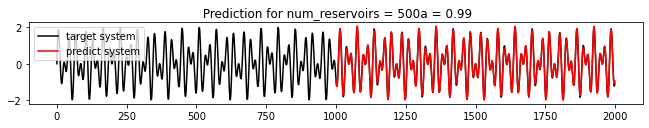

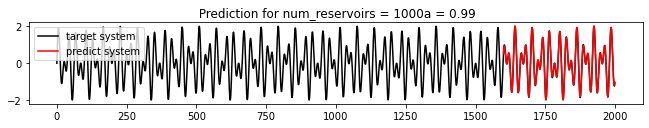

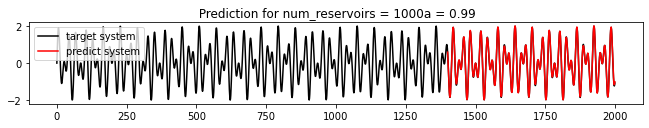

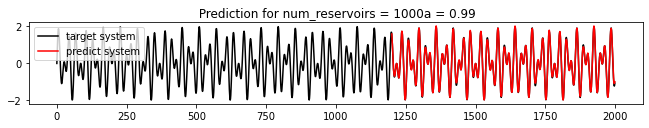

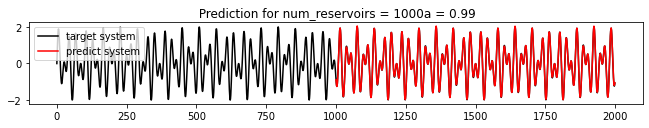

In [377]:
n_reservoirs = [200, 300, 400, 500, 1000]
test_size = [0.2, 0.3, 0.4, 0.5] # training_size = 1 - test_size

for num_reservoir in n_reservoirs:
    for size in test_size:
        io_pair, sin_train_pair, sin_test_pair = train_test_split(sin_data,test_size=size)
        sin_current_state, sin_W_in, sin_W_r, sin_W_out = ESN_train(sin_train_pair, n_reservoirs=num_reservoir)
        sin_test_loss, sin_targets, sin_predicts = ESN_k_step_predict(sin_test_pair,
                                                          sin_current_state,
                                                          sin_W_in,
                                                          sin_W_r,
                                                          sin_W_out)
        print('for num reservoirs = ' + str(num_reservoir) + ' and training_size = ' + str(1-size) + ' --> NRMSE loss: '+ str(sin_test_loss))
        plot_function(sin_data, sin_predicts, k, a, num_reservoir)

for k = 1 --> MSE loss: 3.853371910757828e-07
for k = 20 --> MSE loss: 0.0003021936890425103
for k = 30 --> MSE loss: 0.0002482983573838116
for k = 50 --> MSE loss: 5.5030881198038366e-05
for k = 100 --> MSE loss: 0.0001266714121440414


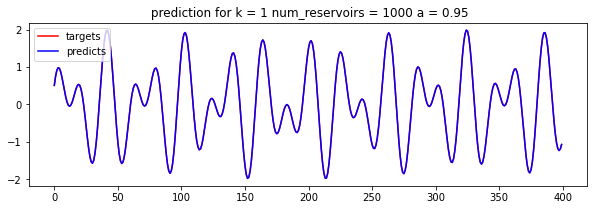

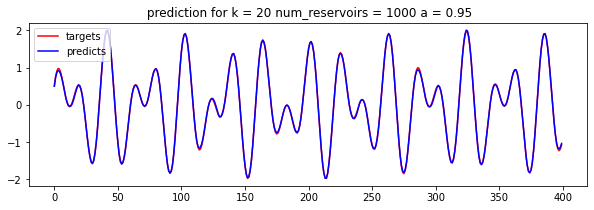

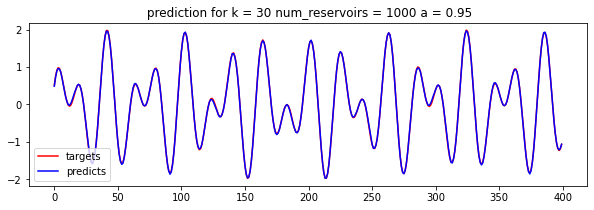

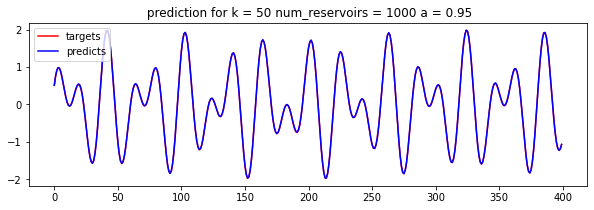

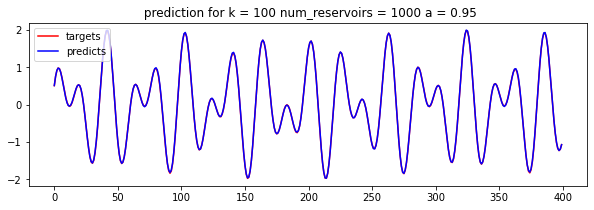

In [378]:
k_tests = [1, 20, 30, 50, 100]

for k in k_tests: 
    io_pair, sin_train_pair, sin_test_pair = train_test_split(sin_data, k=k, test_size=0.2)
    sin_current_state, sin_W_in, sin_W_r, sin_W_out = ESN_train(sin_train_pair, n_reservoirs=1000)
    sin_test_loss, sin_targets, sin_predicts = ESN_k_step_predict(sin_test_pair,
                                                          sin_current_state,
                                                          sin_W_in,
                                                          sin_W_r,
                                                          sin_W_out,
                                                          k=k)
    print('for k = ' + str(k) + ' --> MSE loss: '+ str(sin_test_loss))
    plot_result_function(sin_targets, sin_predicts, k, 0.95, 1000)